In [ ]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_data = np.load('/content/drive/My Drive/Data Arrays/ATLASX_uint8.npy')
input_label = np.load('/content/drive/My Drive/Data Arrays/ATLASY_uint8.npy')

In [ ]:
inp_data = []
inp_label = []
for i in range(len(input_label)):
    r = np.sum(input_label[i]) / input_label[i].size
    if r > 0.05:
        inp_data.append(input_data[i].copy())
        inp_label.append(input_label[i].copy())


inp_data = np.array(inp_data)
inp_label = np.array(inp_label)

In [ ]:
images = inp_data / 255.0
masks = inp_label

In [ ]:
images.shape

(2183, 256, 256, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2D(128, (2, 2), activation='relu', padding='same')(u5)
    u5 = concatenate([u5, c3], axis=3)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(64, (2, 2), activation='relu', padding='same')(u6)
    u6 = concatenate([u6, c2], axis=3)

    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(32, (2, 2), activation='relu', padding='same')(u7)
    u7 = concatenate([u7, c1], axis=3)

    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         18496     ['max_pooling2d[0][0]']   

In [ ]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2 )
# Evaluate the model
# test_loss, test_accuracy = model.evaluate(X_test, y_test)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
175/175 [==============================] - 53s 229ms/step - loss: 0.2900 - accuracy: 0.8944 - val_loss: 0.2218 - val_accuracy: 0.8920
Epoch 2/50
175/175 [==============================] - 30s 170ms/step - loss: 0.1911 - accuracy: 0.9179 - val_loss: 0.1590 - val_accuracy: 0.9298
Epoch 3/50
175/175 [==============================] - 30s 170ms/step - loss: 0.1280 - accuracy: 0.9459 - val_loss: 0.1157 - val_accuracy: 0.9502
Epoch 4/50
175/175 [==============================] - 30s 170ms/step - loss: 0.0979 - accuracy: 0.9598 - val_loss: 0.0976 - val_accuracy: 0.9601
Epoch 5/50
175/175 [==============================] - 31s 175ms/step - loss: 0.0783 - accuracy: 0.9687 - val_loss: 0.0817 - val_accuracy: 0.9681
Epoch 6/50
175/175 [==============================] - 30s 169ms/step - loss: 0.0693 - accuracy: 0.9726 - val_loss: 0.0623 - val_accuracy: 0.9758
Epoch 7/50
175/175 [==============================] - 30s 172ms/step - loss: 0.0575 - accuracy: 0.9775 - val_loss: 0.0521 - val_ac

In [ ]:
model.save('unet_model_0506.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('unet_model_0506.h5')

(256, 256, 1)
1/1 [==============================] - 0s 26ms/step


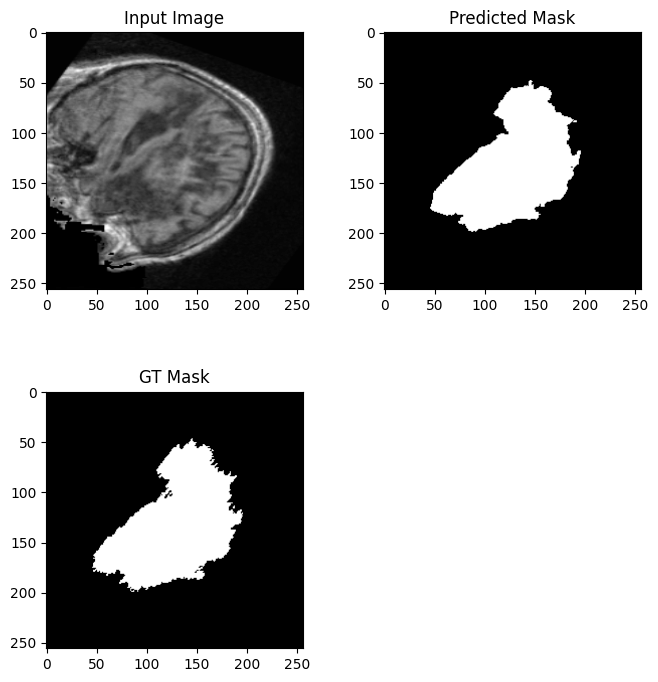

In [ ]:
id = 300

img = images[id]
lbl = masks[id]
print(img.shape)
pred = model.predict(np.expand_dims(img, axis=0))[0]  # Model expects input in batch format

pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(lbl, cmap='gray')
plt.title('GT Mask')

# Adjust the vertical spacing
plt.subplots_adjust(hspace=0.4)

plt.show()

In [ ]:
predictions = model.predict(X_test)
ground_truth = y_test

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

def compute_iou(pred, gt):
    # Flatten the arrays
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()

    # Calculate intersection and union
    intersection = np.sum((pred_flat == 1) & (gt_flat == 1))
    union = np.sum((pred_flat == 1) | (gt_flat == 1))

    # Compute IoU
    if union == 0:
        return 0.0
    else:
        return intersection / union

# Calculate IoU for each pair of predicted and ground truth mask
ious = []
for i in range(predictions.shape[0]):
    iou = compute_iou(predictions[i], ground_truth[i])
    ious.append(iou)

# Compute the average IoU
average_iou = np.mean(ious)

print(f"Average IoU: {average_iou}")

14/14 [==============================] - 15s 583ms/step
Average IoU: 0.9131002573283159


# AIIMS Dataset


In [ ]:
pip install nibabel


In [ ]:
import nibabel as nib
import numpy as np

# Load the NIfTI file
nifti_file = 'ss_anita_1.nii.gz'
img = nib.load(nifti_file)

data = img.get_fdata()
data_normalized = data
# Normalize the data to the range [0, 1]
data_min = np.min(data)
data_max = np.max(data)
data_normalized = (data - data_min) / (data_max - data_min)

# Print the shape and data type of the normalized data
print("Shape of the data (normalized):", data_normalized.shape)
print("Data type (normalized):", data_normalized.dtype)
print("Min value (normalized):", np.min(data_normalized))
print("Max value (normalized):", np.max(data_normalized))

# Convert to uint8
# data_uint8 = data_normalized.astype(np.uint8)

# # Print the shape and data type of the uint8 data
# print("Shape of the data (uint8):", data_uint8.shape)
# print("Data type (uint8):", data_uint8.dtype)
# print("Min value (uint8):", np.min(data_uint8))
# print("Max value (uint8):", np.max(data_uint8))

Shape of the data (normalized): (256, 256, 256)
Data type (normalized): float64
Min value (normalized): 0.0
Max value (normalized): 1.0


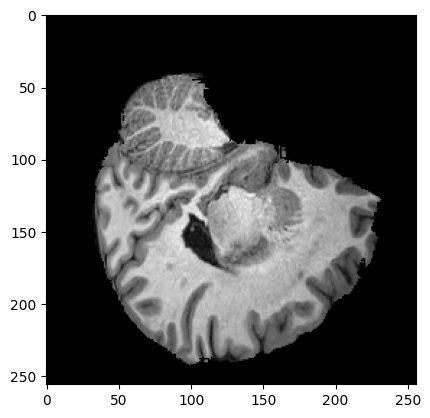

In [ ]:
plt.imshow(data_normalized[100],cmap = 'gray')

In [ ]:
start_id = 0
end_id = 255
lesion = 0

for idd in range(start_id, end_id + 1):
  img = data_normalized[idd]
  img = np.reshape(img, (256, 256, 1))
  # print(img.shape)
  pred = model.predict(np.expand_dims(img, axis=0))[0]  # Model expects input in batch format

  pred[pred < 0.5] = 0
  pred[pred >= 0.5] = 1
  lesion += np.sum(pred)

  # plt.figure(figsize=(8,8))
  # plt.subplot(2, 2, 1)
  # plt.imshow(img, cmap='gray')
  # plt.title('Input Image ' + str (idd) )

  # plt.subplot(2, 2, 2)
  # plt.imshow(pred, cmap='gray')
  # plt.title('Predicted Mask')

  # # Adjust the vertical spacing
  # plt.subplots_adjust(hspace=0.4)

  # plt.show()

1/1 [==============================] - 0s 25ms/step


In [ ]:
img = nib.load(nifti_file)

voxel_dims = img.header.get_zooms()
# print(voxel_dims)
voxel_volume = np.prod(voxel_dims)  # Calculate the volume of a single voxel
# print(voxel_volume)

# Calculate the total brain volume
lesion_volume = lesion * voxel_volume

print(f"Lesion volume: {lesion_volume} cubic millimeters")

Lesion volume: 8898.0 cubic millimeters
